<a href="https://colab.research.google.com/github/ThuTang/DFS-Test/blob/main/DFS_Test_skills.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [2]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1mP0zT_Iulqi9N7eO9lkYNVxZ5GGe8qAunmJ8cTrxQvo/edit#gid=1102027442')

In [3]:
sheet = wb.worksheet('Data').get_all_values()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
df = pd.DataFrame(sheet)
df.columns = df.iloc[0]
df = df.iloc[1:]
df

,Serviceid,Date,User_id
1,20,2018-01-02,40709217
2,20,2018-01-02,40709217
3,984,2018-03-22,18246539
4,269,2018-03-22,18246539
5,666,2018-04-01,18246539
...,...,...,...
1729,268,2018-07-25,40722339
1730,269,2018-07-26,40722339
1731,984,2018-07-26,40722339
1732,333,2018-07-26,40722339


QA part

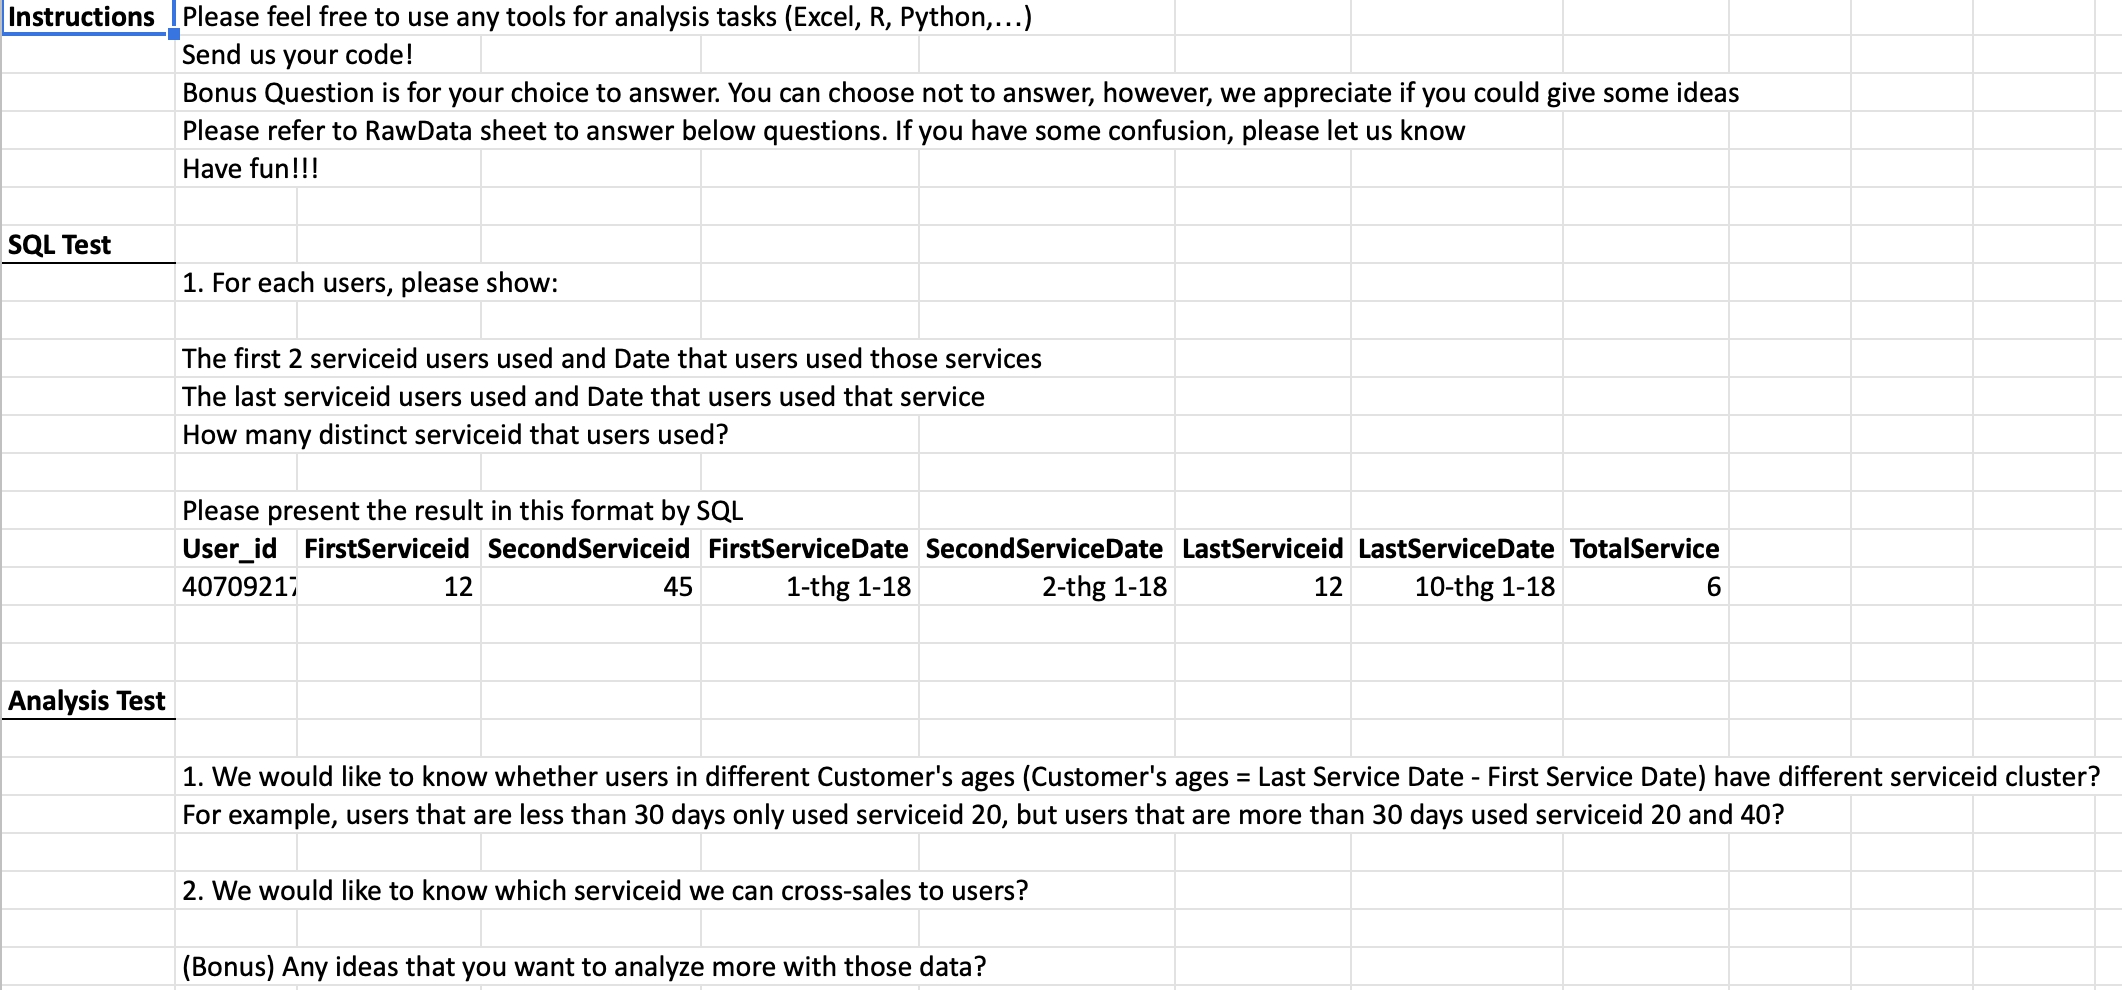

SQL solution:

In [6]:
import sqlite3
con = sqlite3.connect('default.db')

In [7]:
df.to_sql('dfs_data', con, if_exists = 'replace', index = False)

In [8]:
sql = """select * from dfs_data"""

In [9]:
pd.read_sql_query(sql, con)

,Serviceid,Date,User_id
0,20,2018-01-02,40709217
1,20,2018-01-02,40709217
2,984,2018-03-22,18246539
3,269,2018-03-22,18246539
4,666,2018-04-01,18246539
...,...,...,...
1728,268,2018-07-25,40722339
1729,269,2018-07-26,40722339
1730,984,2018-07-26,40722339
1731,333,2018-07-26,40722339


In [10]:
# !curl https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release | tar xz
# %cd sqlite/
# !./configure
# !make sqlite3.c
# %cd /content
# !npx degit coleifer/pysqlite3 -f
# !cp sqlite/sqlite3.[ch] .
# !python setup.py build_static build
# !cp build/lib.linux-x86_64-3.7/pysqlite3/_sqlite3.cpython-37m-x86_64-linux-gnu.so \
#      /usr/lib/python3.7/lib-dynload/

# # then Restart runtime ...
import sqlite3
sqlite3.sqlite_version # 3.36.0

'3.36.0'

Assume that Serviceid will be registered from low to high in order, which means customer will prefer to used small service first (based on Serviceid code).

---



('Cause date stored with format: yyyy-mm-dd not yyyy-mm-dd:hh-mm-ss, so I cannot know which Serviceid have been registered earlier or later with case customer used more than 2 services in 1 day).


In [11]:

sql_table = """ 
create table dfs_tmp as
select b.*, a.total_service, a.last_date
from
(select User_id, count(distinct Serviceid) as total_service, max(Date) as last_date
from dfs_data
group by User_id) a
left join
(select * 
  from
    (select *, row_number () over (partition by User_id order by Date asc, Serviceid asc) as rn
    from dfs_data)
  where rn in (1,2)
) b
on a.User_id = b.User_id
    """

In [12]:
cur = con.cursor()

In [13]:
cur.execute(sql_table)

In [14]:
sql = """ select * from dfs_tmp"""

In [15]:
pd.read_sql_query(sql, con)

,Serviceid,Date,User_id,rn,total_service,last_date
0,20,2018-01-01,11642209,1,14,2018-06-29
1,326,2018-01-02,11642209,2,14,2018-06-29
2,269,2018-03-22,18246539,1,4,2018-04-01
3,984,2018-03-22,18246539,2,4,2018-04-01
4,11,2018-01-01,20831230,1,4,2018-02-08
...,...,...,...,...,...,...
83,487,2018-01-11,40749915,2,7,2018-07-05
84,13,2018-01-07,40750022,1,7,2018-06-29
85,268,2018-01-08,40750022,2,7,2018-06-29
86,310,2018-01-22,4958104,1,7,2018-06-30


In [16]:
sql = """ 
select a.User_id, a.FirstServiceid, b.SecondServiceid, a.FristServiceDate, b.SecondServiceDate, c.LastServiceid, c.LastServiceDate, a.TotalService
from
  (select User_id, Serviceid as FirstServiceid, Date as FristServiceDate, total_service as TotalService
  from dfs_tmp
  where rn = 1) a
left join
  (select User_id, Serviceid as SecondServiceid, Date as SecondServiceDate
  from dfs_tmp
  where rn = 2) b
on a.User_id = b.User_id
left join
  (select User_id, Date as LastServiceDate, max(Serviceid) as LastServiceid
  from dfs_data m 
  where exists (select distinct User_id, last_date from dfs_tmp n where m.User_id = n.User_id and m.Date = n.last_date)
  group by User_id, Date) c
  on a.User_id = c.User_id   """

pd.read_sql_query(sql, con)

,User_id,FirstServiceid,SecondServiceid,FristServiceDate,SecondServiceDate,LastServiceid,LastServiceDate,TotalService
0,11642209,20,326,2018-01-01,2018-01-02,666,2018-06-29,14
1,18246539,269,984,2018-03-22,2018-03-22,666,2018-04-01,4
2,20831230,11,333,2018-01-01,2018-01-01,1366,2018-02-08,4
3,21307673,1014,18,2018-01-03,2018-01-03,983,2018-07-27,10
4,2464231,18,333,2018-01-07,2018-01-16,982,2018-07-23,10
5,25674126,1136,333,2018-01-02,2018-01-02,981,2018-07-26,12
6,30456022,18,481,2018-01-03,2018-01-03,481,2018-03-03,2
7,31485023,1014,18,2018-01-03,2018-01-03,398,2018-01-10,4
8,36142806,1014,18,2018-01-04,2018-01-04,982,2018-07-03,14
9,36301869,273,65,2018-01-04,2018-01-04,982,2018-07-26,25


Analysis Solution - using python

In [17]:
# using table from sql solution: users, age, service, freq

sql_table = """ create table dfs_analysis_total as
select a.*, b.Serviceid, b.freq
from
  (select User_id, min(Date) as first_date, max(Date) as last_date, count(distinct Serviceid) as total_service
      from dfs_data
      group by User_id) a 
left join
  (select User_id, Serviceid, count(1) as freq 
      from dfs_data
      group by User_id, Serviceid) b
on a.User_id = b.User_id
                 """

cur.execute(sql_table)

In [18]:
sql = """ select * from dfs_analysis_total """
data_total = pd.read_sql_query(sql, con)
data_total

,User_id,first_date,last_date,total_service,Serviceid,freq
0,11642209,2018-01-01,2018-06-29,14,1014,2
1,11642209,2018-01-01,2018-06-29,14,20,47
2,11642209,2018-01-01,2018-06-29,14,259,1
3,11642209,2018-01-01,2018-06-29,14,268,1
4,11642209,2018-01-01,2018-06-29,14,270,2
...,...,...,...,...,...,...
315,4958104,2018-01-22,2018-06-30,7,310,9
316,4958104,2018-01-22,2018-06-30,7,333,15
317,4958104,2018-01-22,2018-06-30,7,64,9
318,4958104,2018-01-22,2018-06-30,7,667,15


In [19]:
# sql_table  = """ drop table dfs_analysis_month  """
# cur.execute(sql_table)

In [20]:
sql_table  = """ create table dfs_analysis_month as
select a.*, b.Serviceid, b.freq
from
(select User_id, substring(Date, 1,8) as partition_month, min(Date) as first_date, max(Date) as last_date, count(distinct Serviceid) as total_service
      from dfs_data
      group by User_id, substring(Date, 1,8)) a 
left join
  (select User_id, substring(Date, 1,8) as partition_month, Serviceid, count(1) as freq 
      from dfs_data
      group by User_id, substring(Date, 1,8) , Serviceid) b
on a.User_id = b.User_id
and a.partition_month = b.partition_month """
cur.execute(sql_table)

In [21]:
sql = """ select * from dfs_analysis_month """
data_month = pd.read_sql_query(sql, con)
data_month

,User_id,partition_month,first_date,last_date,total_service,Serviceid,freq
0,11642209,2018-01,2018-01-01,2018-01-28,11,1014,1
1,11642209,2018-01,2018-01-01,2018-01-28,11,20,11
2,11642209,2018-01,2018-01-01,2018-01-28,11,268,1
3,11642209,2018-01,2018-01-01,2018-01-28,11,270,1
4,11642209,2018-01,2018-01-01,2018-01-28,11,326,9
...,...,...,...,...,...,...,...
656,4958104,2018-06,2018-06-14,2018-06-30,6,273,1
657,4958104,2018-06,2018-06-14,2018-06-30,6,310,1
658,4958104,2018-06,2018-06-14,2018-06-30,6,333,2
659,4958104,2018-06,2018-06-14,2018-06-30,6,64,1


In [22]:
data_total.dtypes

User_id          object
first_date       object
last_date        object
total_service     int64
Serviceid        object
freq              int64
dtype: object

In [23]:
data_total['last_date'] = pd.to_datetime(data_total['last_date'])
data_total['first_date'] = pd.to_datetime(data_total['first_date'])

data_month['last_date'] = pd.to_datetime(data_month['last_date'])
data_month['first_date'] = pd.to_datetime(data_month['first_date'])

In [24]:
data_total['customer_age'] = (data_total['last_date'] - data_total['first_date']).dt.days
data_month['customer_age'] = (data_month['last_date'] - data_month['first_date']).dt.days

In [25]:
data_total

,User_id,first_date,last_date,total_service,Serviceid,freq,customer_age
0,11642209,2018-01-01,2018-06-29,14,1014,2,179
1,11642209,2018-01-01,2018-06-29,14,20,47,179
2,11642209,2018-01-01,2018-06-29,14,259,1,179
3,11642209,2018-01-01,2018-06-29,14,268,1,179
4,11642209,2018-01-01,2018-06-29,14,270,2,179
...,...,...,...,...,...,...,...
315,4958104,2018-01-22,2018-06-30,7,310,9,159
316,4958104,2018-01-22,2018-06-30,7,333,15,159
317,4958104,2018-01-22,2018-06-30,7,64,9,159
318,4958104,2018-01-22,2018-06-30,7,667,15,159


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac771d4050>]],
      dtype=object)

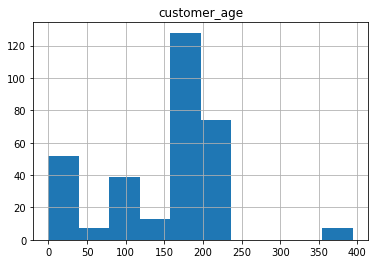

In [26]:
data_total[['customer_age']].hist()

In [27]:
data_total['customer_age'].describe()

count    320.00000
mean     150.08750
std       75.19466
min        0.00000
25%       99.00000
50%      177.00000
75%      197.00000
max      394.00000
Name: customer_age, dtype: float64

In [28]:
 label_bin = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
 data_total['customer_age_bin'] = pd.qcut(data_total['customer_age'], q=10, precision=0, labels = label_bin)
 data_total['customer_age_bin'].value_counts()

7     37
5     36
6     34
4     34
2     34
1     34
9     31
3     30
10    29
8     21
Name: customer_age_bin, dtype: int64

In [29]:
data_total.groupby("customer_age_bin").customer_age.unique()

customer_age_bin
1       [10, 7, 0, 17, 3, 2, 21, 23]
2           [38, 59, 97, 34, 44, 33]
3                [115, 106, 99, 118]
4     [162, 145, 169, 144, 148, 159]
5                    [177, 175, 173]
6                    [179, 180, 178]
7                    [196, 192, 184]
8                         [197, 199]
9                         [203, 200]
10                        [205, 394]
Name: customer_age, dtype: object

In [30]:
data_total.to_sql('dfs_analysis_customer_bin', con, if_exists = 'replace', index = False)

In [31]:
sql = """
select * from dfs_analysis_customer_bin
"""
pd.read_sql_query(sql,con)

,User_id,first_date,last_date,total_service,Serviceid,freq,customer_age,customer_age_bin
0,11642209,2018-01-01 00:00:00,2018-06-29 00:00:00,14,1014,2,179,6
1,11642209,2018-01-01 00:00:00,2018-06-29 00:00:00,14,20,47,179,6
2,11642209,2018-01-01 00:00:00,2018-06-29 00:00:00,14,259,1,179,6
3,11642209,2018-01-01 00:00:00,2018-06-29 00:00:00,14,268,1,179,6
4,11642209,2018-01-01 00:00:00,2018-06-29 00:00:00,14,270,2,179,6
...,...,...,...,...,...,...,...,...
315,4958104,2018-01-22 00:00:00,2018-06-30 00:00:00,7,310,9,159,4
316,4958104,2018-01-22 00:00:00,2018-06-30 00:00:00,7,333,15,159,4
317,4958104,2018-01-22 00:00:00,2018-06-30 00:00:00,7,64,9,159,4
318,4958104,2018-01-22 00:00:00,2018-06-30 00:00:00,7,667,15,159,4


In [32]:
# Considering customers using multiple services(eg: n services) like n individual objects 

sql = """
select a.*, b.Serviceid, b.total_service_user, b.total_service_register, b.avg_total_service
  , round(cast(b.total_service_user as REAL)/cast(a.total_user as REAL),3) as pct_total_user
  , round(cast(b.total_service_register as REAL)/cast(a.total_register as REAL),3) as pct_total_register
  from
(select customer_age_bin, count(distinct User_id) as total_user, sum(freq) as total_register
from dfs_analysis_customer_bin
group by customer_age_bin) a
left join
(select customer_age_bin, Serviceid, count(distinct User_id) as total_service_user, sum(freq) as total_service_register, avg(total_service) as avg_total_service
from  dfs_analysis_customer_bin
group by customer_age_bin, Serviceid) b 
on a.customer_age_bin = b.customer_age_bin
"""
data_cluster_all = pd.read_sql_query(sql,con)


In [33]:
data_cluster_all

,customer_age_bin,total_user,total_register,Serviceid,total_service_user,total_service_register,avg_total_service,pct_total_user,pct_total_register
0,1,10,54,1014,5,10,3.6,0.5,0.185
1,1,10,54,1136,1,3,2.0,0.1,0.056
2,1,10,54,18,1,1,4.0,0.1,0.019
3,1,10,54,19,1,1,4.0,0.1,0.019
4,1,10,54,20,2,3,2.0,0.2,0.056
...,...,...,...,...,...,...,...,...,...
225,9,2,311,668,1,1,25.0,0.5,0.003
226,9,2,311,68,1,2,25.0,0.5,0.006
227,9,2,311,981,1,25,25.0,0.5,0.080
228,9,2,311,982,2,44,15.5,1.0,0.141


In [34]:
data_cluster_all['total_service_user'].unique()

array([5, 1, 2, 3, 4])

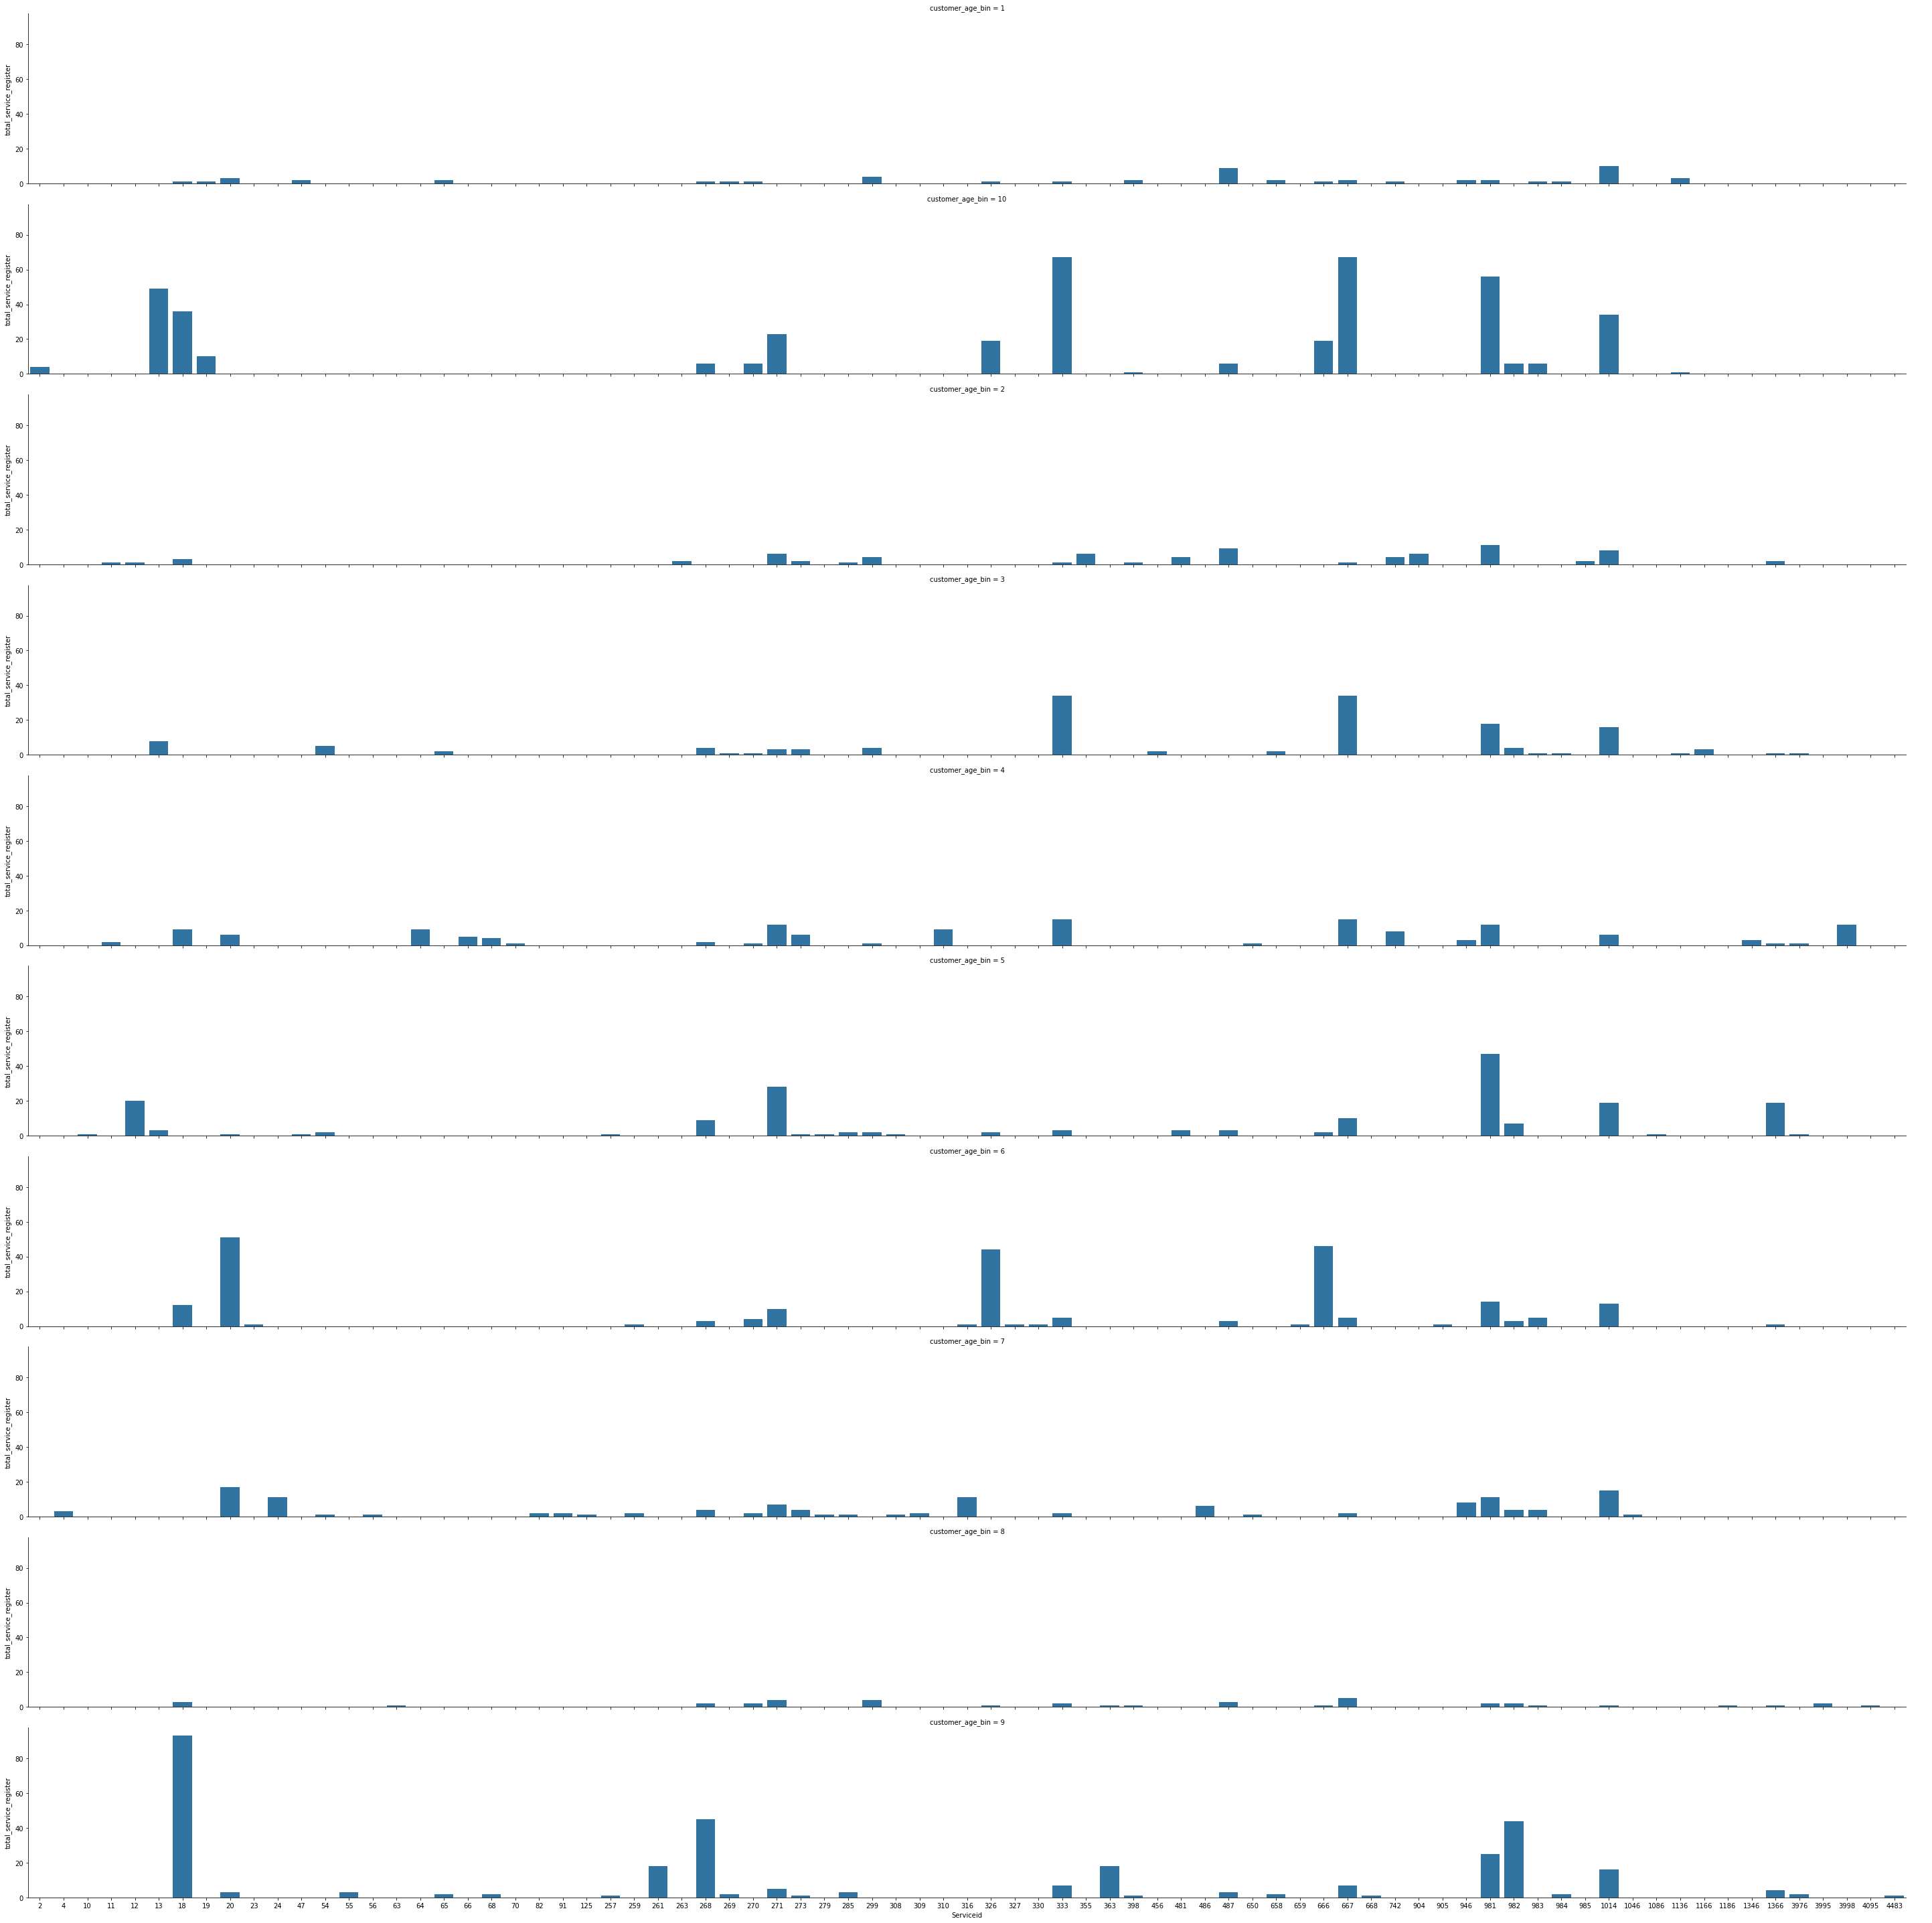

In [35]:
import seaborn as sns
orders = ['2',	'4',	'10',	'11',	'12',	'13',	'18',	'19',	'20',	'23',	'24',	'47',	'54',	
          '55',	'56',	'63',	'64',	'65',	'66',	'68',	'70',	'82',	'91',	'125',	'257',	
          '259',	'261',	'263',	'268',	'269',	'270',	'271',	'273',	'279',	'285',	
          '299',	'308',	'309',	'310',	'316',	'326',	'327',	'330',	'333',	'355',	'363',	
          '398',	'456',	'481',	'486',	'487',	'650',	'658',	'659',	'666',	'667',	'668',	
          '742',	'904',	'905',	'946',	'981',	'982',	'983',	'984',	'985',	'1014',	'1046',	
          '1086',	'1136',	'1166',	'1186',	'1346',	'1366',	'3976',	'3995',	'3998',	'4095',	'4483']

g = sns.FacetGrid(data_cluster_all, row ="customer_age_bin", height=4, aspect=10)
g.map(sns.barplot, "Serviceid", "total_service_register", order = orders)
g.add_legend()

In [36]:
# pip install --upgrade plotly

In [37]:
data_total.groupby("customer_age_bin").customer_age.unique()

customer_age_bin
1       [10, 7, 0, 17, 3, 2, 21, 23]
2           [38, 59, 97, 34, 44, 33]
3                [115, 106, 99, 118]
4     [162, 145, 169, 144, 148, 159]
5                    [177, 175, 173]
6                    [179, 180, 178]
7                    [196, 192, 184]
8                         [197, 199]
9                         [203, 200]
10                        [205, 394]
Name: customer_age, dtype: object

In [38]:
import plotly.express as px

fig = px.treemap(data_cluster_all, 
                 path=['customer_age_bin', 'Serviceid'], 
                 values='total_service_register',
                 color='total_service_register',
                 title = 'Total registers of each service in customers age clusters'
                )
fig.show()

# moving mouse and click inside each block in treemap below to zoom in (if you're not familier with plotly)

In [39]:
pie_viz = data_cluster_all[['customer_age_bin', 'total_register']].drop_duplicates()
pie_viz

,customer_age_bin,total_register
0,1,54
23,10,416
41,2,75
61,3,149
83,4,144
107,5,190
133,6,226
155,7,127
183,8,41
204,9,311


In [40]:
fig = px.pie(pie_viz, values='total_register', names='customer_age_bin')
fig.show()

Nhận xét:

1.   Dựa vào tổng số lượt đăng ký dịch vụ của từng cluster service, có thể chia thành 4 nhóm theo thứ tự giảm dần như :

*   Nhóm 1: Cluster 10 + 9 (độ tuổi trong khoảng 200 - 394 ngày tương đương với khoảng từ 6 - 13 tháng) - nhóm tuổi cao - KH thân thiết
  + số lượt đăng ký dịch vụ nhiều nhất với tổng số lượt đăng ký là 727, chiếm 42% tổng số lượt đăng ký của toàn bộ tập khách hàng (tính từ tháng 05/2017 đến 07/2018)
  + số lượt đăng ký của mỗi cluster trong nhóm > 300 lượt/14 tháng



*   Nhóm 2: Cluster 6+5 (độ tuổi trong khoảng 144 - 180 ngày tương đương với khoảng 4 - 6 tháng) - nhóm tuổi trung bình cao - KH quen
  + tổng số lượt đăng ký 416, chiếm 24% tổng số lượt đăng ký toàn tập khách hàng
  + số lượt đăng ký của mỗi cluster trong nhóm dao động trong khoảng 200 - 220 lượt/14 tháng

*   Nhóm 3: Cluster 3+4+7 (độ tuổi 99 - 169 ngày và 184 - 196 ngày) - nhóm tuổi trung bình hoặc đăng ký ít
  + tổng số lượt đăng ký 420, chiếm 24% số lượt đăng ký toàn tập khách hàng
  + số lượt đăng ký của mỗi cluster trong nhóm dao động trong khoảng 130 - 140 lượt/14 
*   Nhóm 4: Cluster 1+2+8 (độ tuổi 0 - 97 ngày và 197 - 199 ngày) - nhóm tuổi thấp hoặc đăng ký ít (khách hàng mới hoặc ít nhu cầu/không tiếp cận được các nhóm sản phẩm mới...)
  + tổng số lượt đăng ký 170, chiếm 10% số lượt đăng ký của toàn tập khách hàng
  + số lượt đăng ký của mỗi cluster < 76 lượt/14 tháng




2.   Dựa vào top x services được đăng ký nhiều nhất:



*   Top 5: Serviceid 981 được ưa thích ở hầu hết các clusters (ngoại trừ nhóm cluster 1 và 8 với tổng số lượt đăng ký trên mỗi cluster < 60 lượt/14 tháng)
*   Top 10: Serviceid 1014 và 667 được ưa thích ở hầu hết các cluster, trong đó service 667 được đăng ký nhiều ở phân khúc nhóm khách hàng nhóm tuổi trung bình (cluster 3+4) trong khi serviceid 1014 lại được ưa chuộng hơn với nhóm khách hàng mới (cluster 1+2)



3.   Phân nhóm dựa theo độ tuổi, mỗi 2 cluster sẽ được xếp thành 1 nhóm bao gồm: (10+9); (8+7);  (6+5); (4+3); (2+1)


*   Dựa theo các nhóm phân theo độ tuổi, nhận thấy top 10 sản phẩm của từng cluster trong nhóm sẽ match với nhau trung bình khoảng 30%

  => Với mỗi cluster (tính theo tuổi của khách hàng) sẽ có các đặc điểm sử dụng các dịch vụ khác nhau, tuy nhiên, danh sách top 10 các serviceid của các khách hàng trong mỗi nhóm (5 nhóm miêu tả bên trên) sẽ match khoảng 30% 
#  ***=> Các khách hàng ở các cluster cùng 1 nhóm sẽ có xu hướng sử dụng các cluster service giống nhau (trong khoảng 30%), khách hàng ở khác nhóm thì cluster service cũng khác nhau (ngoại trừ các sản phẩm 981, 1014, 667 thì độ match giữa các service chỉ khoảng 10% hoặc ít hơn)***
*   Xếp theo mức độ tăng tiến về độ tuổi, các nhóm khách hàng tuổi cao có xu hướng đăng ký sử dụng dịch vụ nhiều hơn (hoặc ít hơn không đáng kể) so với các nhóm khách hàng tuổi thấp hơn. 

  Tuy nhiên riêng với nhóm 7+8 (độ tuổi từ 184 - 199 ngày tương đương với khoảng hơn 6 tháng) có xu hướng tiêu dùng ít đi (đi ngược lại với trend)

  => Nghi ngờ churn hoặc không được tiếp cận với các nhóm sản phẩm mới hoặc chuyển vùng nên không có nhu cầu...

# ***4. Cross-sale:***


*   Với các sản phẩm như 981, 1014, 667 thì có thể ưu tiên mời đại trà với tất cả các nhóm khách hàng (ví dụ nếu KH đang sử dụng dịch vụ này thì có thể mời sử dụng thêm 1 trong 3 sản phẩm này hoặc cả 3) theo thứ tự:
  + Phân khúc tuổi cao: Serviceid 981 -> Serviceid 1014 -> Serviceid 667
  + Phân khúc tuổi thấp: Serviceid 981 -> Serviceid 667 -> Serviceid 1014
  
*   Ngoài 3 sản phẩm trên, với các nhóm tuổi (5 nhóm bên trên), có thể mời top 5 sản phẩm match giữa các clusters trong cùng 1 nhóm để cross - sale trước, sau đó mời đến các sản phẩm (981, 1014, 667) 

* Riêng với nhóm 7 + 8 nên tập trung mời các sản phẩm (981, 1014, 667) hoặc thêm ưu đãi các nhóm sản phẩm top 5 họ đang sử dụng để gìn giữ khách hàng











In [41]:
fig = px.treemap(data_cluster_all, 
                 path=['customer_age_bin', 'Serviceid'], 
                 values='pct_total_register',
                 color='pct_total_register',
                 title = 'Total percentage registers of each service in customers age clusters'
                )
fig.show()

Nhận xét:

Với trường hợp số lượt đăng ký tại mỗi cluster quá khác nhau, ngoài việc sử dụng số tuyệt đối để phân tích, có thể sử dụng số tương đối (như tỷ lệ %,...) để đánh giá tổng quan

Biểu đồ treemap trên cho thấy sự phân bố về % số lượt đăng ký các dịch vụ tại từng clusters cho thấy sự khác biệt về hành vi, đặc điểm sử dụng dịch vụ của mỗi nhóm khách hàng

=> Các nhóm sản phẩm top 5 đã chiếm từ 50 - 60% hoặc hơn số lượt đăng ký của toàn bộ sản phẩm

=> Với mỗi nhóm khách hàng khi cross-sale, chỉ cần quan tâm đến top 5 sản phẩm match giữa các nhóm là đủ khả năng sẽ mời được khách hàng sử dụng (tiết kiệm chi phí mời dàn trải)

In [42]:
fig = px.treemap(data_cluster_all, 
                 path=['customer_age_bin', 'Serviceid'], 
                 values='total_service_user',
                 color='total_service_user',
                 title = 'Total users registered of each service in customers age clusters'
                )
fig.show()

Nhận xét:

Dựa vào cluster theo độ tuổi khách hàng, mỗi dịch vụ chỉ có khoảng từ 1 - 5 người đăng ký (hoặc 0), khoảng cách là quá nhỏ để có sự khác biệt và ý nghĩa về thống kê

=> Không nhận xét và phân tích dựa vào số lượng người đăng ký 

# ***Bonus question***

Sử dụng dữ liệu theo tháng (dựa vào dataframe: data_month) để xác định:
1. Top sản phẩm được đăng ký sử dụng dịch vụ theo tháng  (số lượt đăng ký, số người sử dụng) để xác định mức độ duy trì - tăng giảm qua các tháng => xu hướng thay đổi sản phẩm của KH
2. Thời gian đăng ký nhiều nhất trong tháng -> có chu kỳ lặp lại giữa các tháng hay không?
3. Tỷ lệ maintain - chuyển đổi dịch vụ qua các tháng của users/nhóm users?
4. Xác định được nhóm dịch vụ ưa thích của user qua tháng và xác định kiểu user?
5. Tỷ lệ đăng ký tăng/giảm với các dịch vụ ưa thích của từng user qua các tháng?

In [43]:
data_month

,User_id,partition_month,first_date,last_date,total_service,Serviceid,freq,customer_age
0,11642209,2018-01,2018-01-01,2018-01-28,11,1014,1,27
1,11642209,2018-01,2018-01-01,2018-01-28,11,20,11,27
2,11642209,2018-01,2018-01-01,2018-01-28,11,268,1,27
3,11642209,2018-01,2018-01-01,2018-01-28,11,270,1,27
4,11642209,2018-01,2018-01-01,2018-01-28,11,326,9,27
...,...,...,...,...,...,...,...,...
656,4958104,2018-06,2018-06-14,2018-06-30,6,273,1,16
657,4958104,2018-06,2018-06-14,2018-06-30,6,310,1,16
658,4958104,2018-06,2018-06-14,2018-06-30,6,333,2,16
659,4958104,2018-06,2018-06-14,2018-06-30,6,64,1,16


In [44]:
sql = """ select * from dfs_analysis_month """
pd.read_sql_query(sql,con)

,User_id,partition_month,first_date,last_date,total_service,Serviceid,freq
0,11642209,2018-01,2018-01-01,2018-01-28,11,1014,1
1,11642209,2018-01,2018-01-01,2018-01-28,11,20,11
2,11642209,2018-01,2018-01-01,2018-01-28,11,268,1
3,11642209,2018-01,2018-01-01,2018-01-28,11,270,1
4,11642209,2018-01,2018-01-01,2018-01-28,11,326,9
...,...,...,...,...,...,...,...
656,4958104,2018-06,2018-06-14,2018-06-30,6,273,1
657,4958104,2018-06,2018-06-14,2018-06-30,6,310,1
658,4958104,2018-06,2018-06-14,2018-06-30,6,333,2
659,4958104,2018-06,2018-06-14,2018-06-30,6,64,1


In [45]:
sql = """
select * from
(select *, row_number () over (partition by partition_month order by number_register desc, number_users desc) as rn
from
(select partition_month, Serviceid, count(distinct User_id) as number_users, sum(freq) as number_register
from dfs_analysis_month
group by partition_month, Serviceid) )
where rn < 8
order by partition_month,  rn 
"""
pd.read_sql_query(sql,con)

,partition_month,Serviceid,number_users,number_register,rn
0,2017-05,2,1,1,1
1,2017-06,2,1,1,1
2,2017-08,2,1,1,1
3,2017-09,2,1,1,1
4,2018-01,981,16,39,1
5,2018-01,667,11,38,2
6,2018-01,333,9,36,3
7,2018-01,1014,16,35,4
8,2018-01,487,10,30,5
9,2018-01,13,2,25,6


In [46]:
# năm 2017 chỉ có mỗi serviceid = 2 với số người đăng ký = số lượt đăng ký = 1 => loại

sql = """
select * from
(select *, row_number () over (partition by partition_month order by number_register desc, number_users desc) as rn
from
(select partition_month, Serviceid, count(distinct User_id) as number_users, sum(freq) as number_register
from dfs_analysis_month
where partition_month like '%2018%'
group by partition_month, Serviceid) )
where rn < 8
order by partition_month,  rn 
"""

data_top_service_month = pd.read_sql_query(sql,con)

In [47]:

fig = px.line(data_top_service_month, x='partition_month', y='number_register', color='Serviceid', markers=True
              , title = 'Top 7 services has been registered most in month from 01/2018 to 07/2018')
fig.show()

Nhận xét:

* Từ 01/2018 - 07/2018, số lượt đăng ký các sản phẩm dịch vụ trong top 7 có xu hướng giảm dần qua thời gian, đặc biệt giảm mạnh ở tháng 02 và tháng 06
* Top 3 services 981, 1014, 667 luôn nằm trong top các dịch vụ được đăng ký nhiều trong khoảng thời gian quan sát
* Từ tháng 04/2018, serviceid 18 có số lượt đăng ký nhiều nhất ~ 39 lượt, cao hơn 1,4 lần so với sản phẩm top 2 (serviceid 981) và cao gấp 2 - 3 lần các sản phẩm còn lại, đồng thời giữ nguyên vị trí top 1 từ tháng 04/2018 đến 07/2018


In [48]:
sql = """ 
select * from
  (select *, row_number () over (partition by partition_month order by number_register desc, number_users desc) as rn
    from
    (select partition_month, date_in_month, count(distinct User_id) as number_users, count(1) as number_register
      from
      (select *, substring(Date,1,8) as partition_month, substring(Date, -2) as date_in_month from dfs_data where Date like '%2018%')
      group by partition_month, date_in_month))
 where rn < 8
order by partition_month, rn      
"""
data_top_day_in_month = pd.read_sql_query(sql,con)

In [56]:
fig = px.scatter(data_top_day_in_month, y="partition_month", x="date_in_month", color="number_register")
fig.update_traces(marker_size=10)
fig.show()

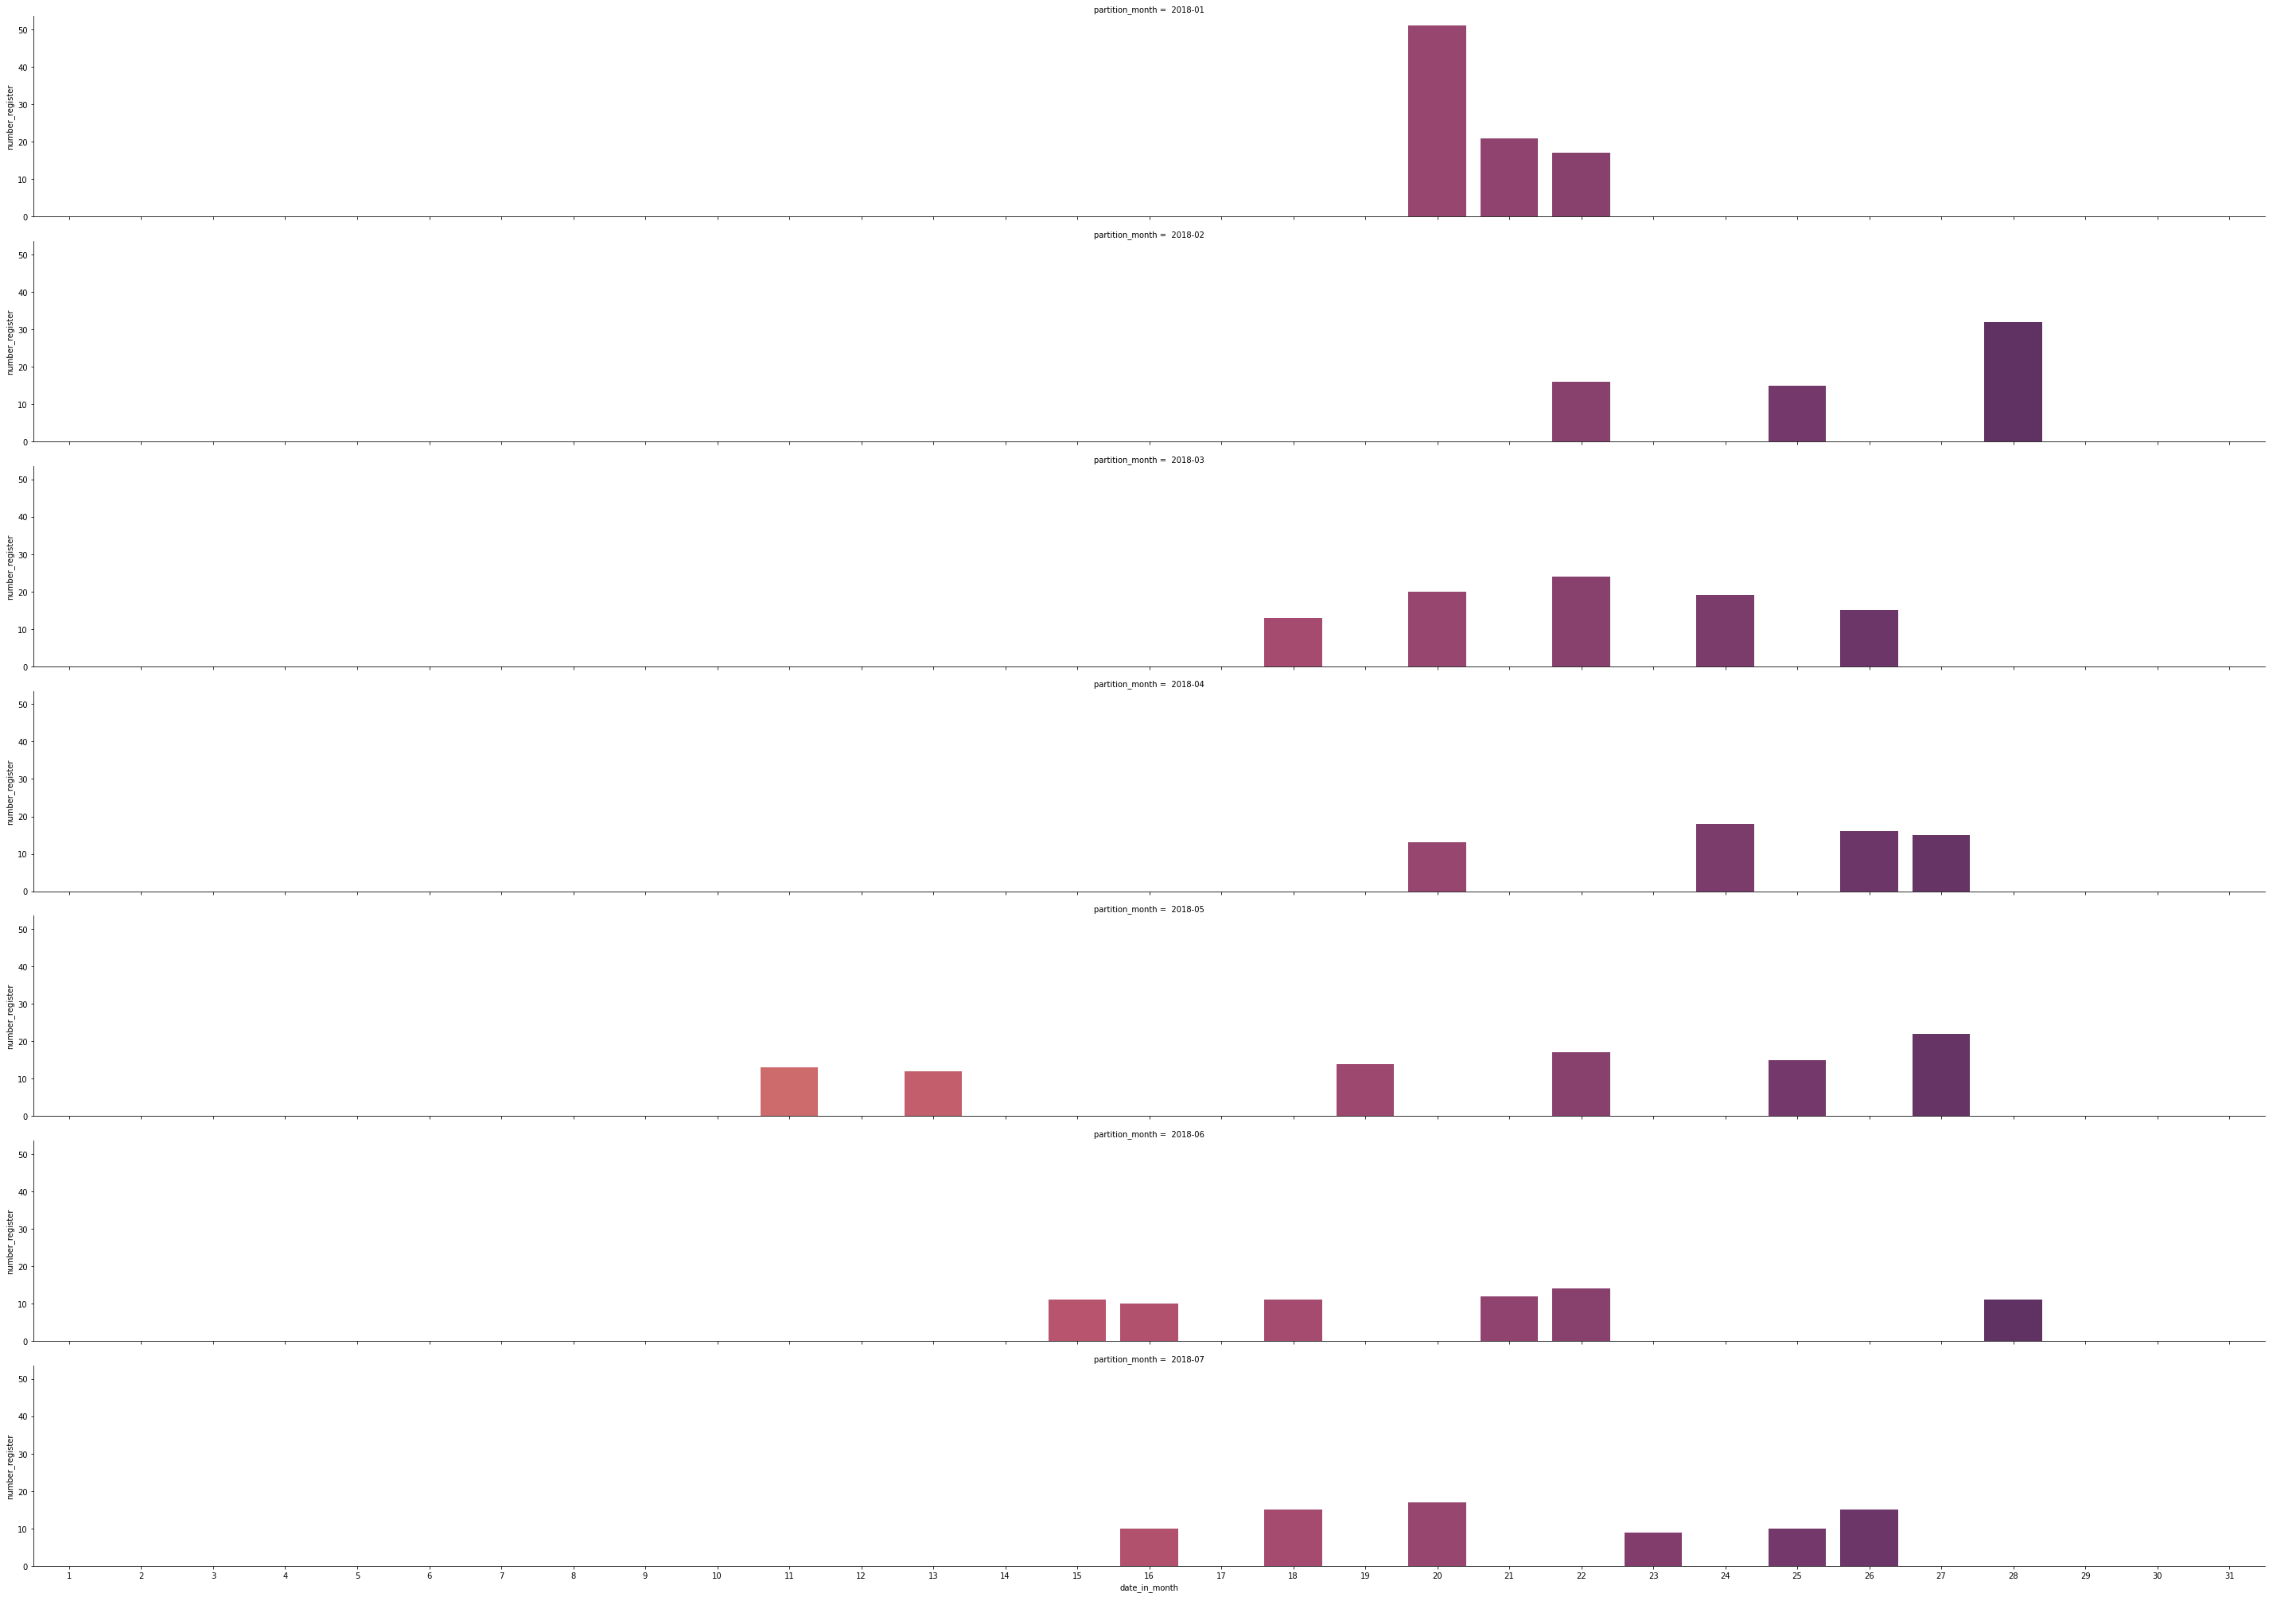

In [59]:
orders = ['1',	'2',	'3',	'4',	'5',	'6',	'7',	'8',	'9',	'10',	
          '11',	'12',	'13',	'14',	'15',	'16',	'17',	'18',	'19',	'20',	
          '21',	'22',	'23',	'24',	'25',	'26',	'27',	'28',	'29',	'30',	'31']

g = sns.FacetGrid(data_top_day_in_month, row ="partition_month", height=4, aspect=10)
g.map(sns.barplot, "date_in_month", "number_register", order = orders, palette = "flare")
g.add_legend()

Nhận xét:

Số lượng đăng ký dịch vụ theo từng ngày qua các tháng tương đối khác nhau, tuy nhiên, tại tất cả các tháng từ 01/2018 đến 07/2018, số lượt đăng ký tập trung từ khoảng 20 - 28 hàng tháng

=> Tập trung các chiến dịch marketing tác động đến khách hàng ngay trước và trong khoảng thời gian này để đạt hiệu quả cao